TODOs
* use contour plot -- DONE
* critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
* generate moving input -- DONE (NEEDS REVIEW)
* h = v * t (v is speed) -- DONE (NEEDS REVIEW)
* add noise from 2020 bioxiv paper


In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
import network_dynamics as ndyn

# Simulation #1 - Fully connected with Gaussian Kernel

We're looking to see that global inhibition is working, that eventually firing rates plateau when there is no longer external input.

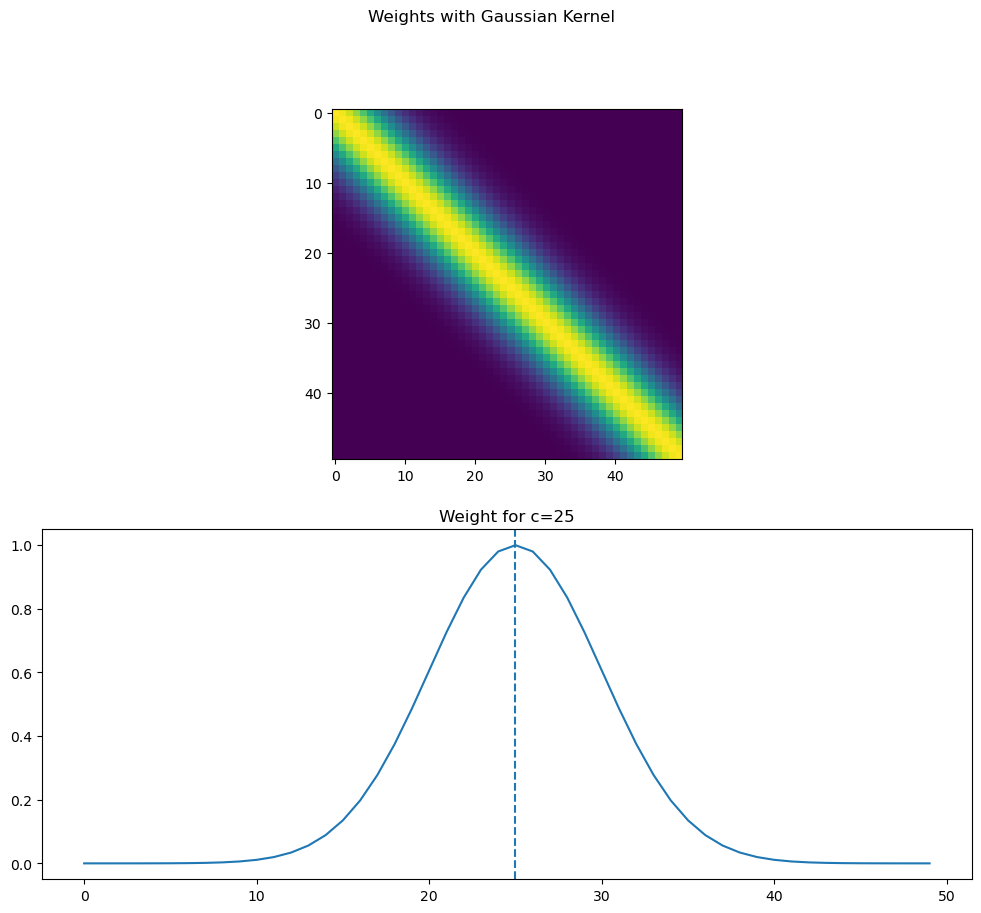

In [88]:
network = ndyn.Network(N=50, T=20)
ndyn.plot_weight(network, 25, 'Weights with Gaussian Kernel')

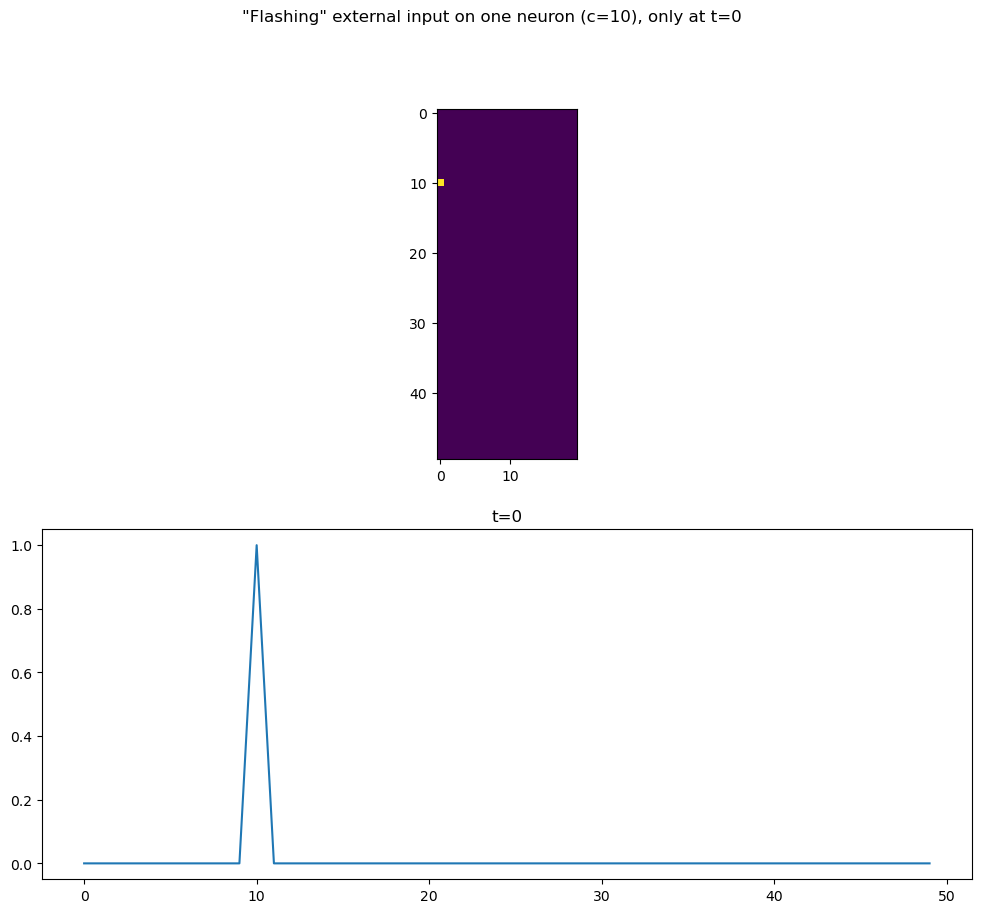

In [101]:
external_input = np.zeros((network.N, network.T))
external_input[10, 0] = 1

ndyn.plot_external_input_at_t(external_input, 0, '"Flashing" external input on one neuron (c=10), only at t=0')

In [90]:
solution = network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0  1 ... 18 19]
        y: [[ 0.000e+00  1.389e-02 ...  3.511e-06  2.995e-06]
            [ 0.000e+00  2.002e-02 ...  4.359e-06  3.718e-06]
            ...
            [ 0.000e+00  3.391e-11 ...  3.818e-12  3.257e-12]
            [ 0.000e+00  1.241e-11 ...  1.734e-12  1.479e-12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 158
     njev: 0
      nlu: 0


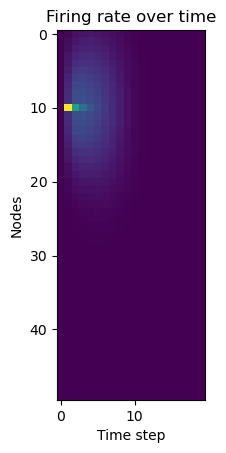

Firing rate diminishes due to global inhibition and a lower recurrent weight


In [91]:
ndyn.plot_firing_rate(network, "Firing rate over time")
print('Firing rate diminishes due to global inhibition and a lower recurrent weight')

# Simulation #2 - "Flashing" external input with strong recurrent weight

We're looking to see that the network maintains the firing rate for a "flashed" input when the recurrent weight is strong.

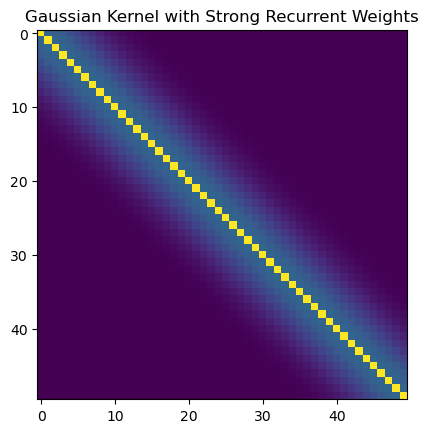

In [92]:
np.fill_diagonal(network.W, 3)
ndyn.plot_weight_matrix(network, 'Gaussian Kernel with Strong Recurrent Weights')

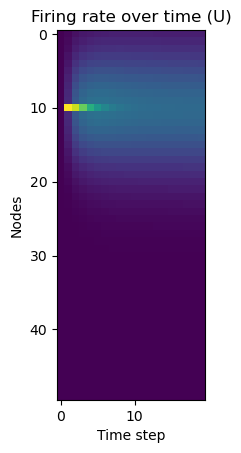

In [93]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation 3 - Constant Stimulus with Gaussian Function

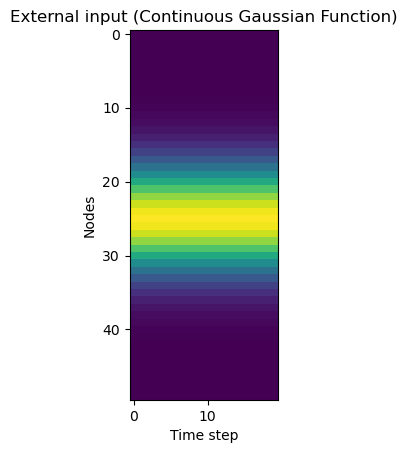

In [94]:
network = ndyn.Network(50, 20)
external_input = ndyn.get_diff_matrix(network.N, 25)
external_input = ndyn.gaussian_func(external_input)
external_input = np.tile(external_input, (1, network.T))
ndyn.plot_external_input(external_input, 'External input (Continuous Gaussian Function)')

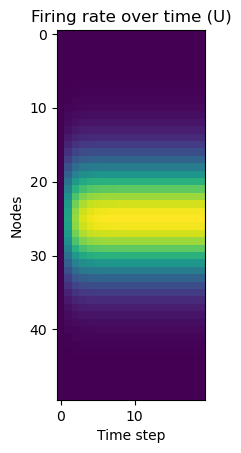

In [95]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation. With the periodic condition, the form of recurrent interactions is adjusted..." (Wu & Amari 2005)

[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]


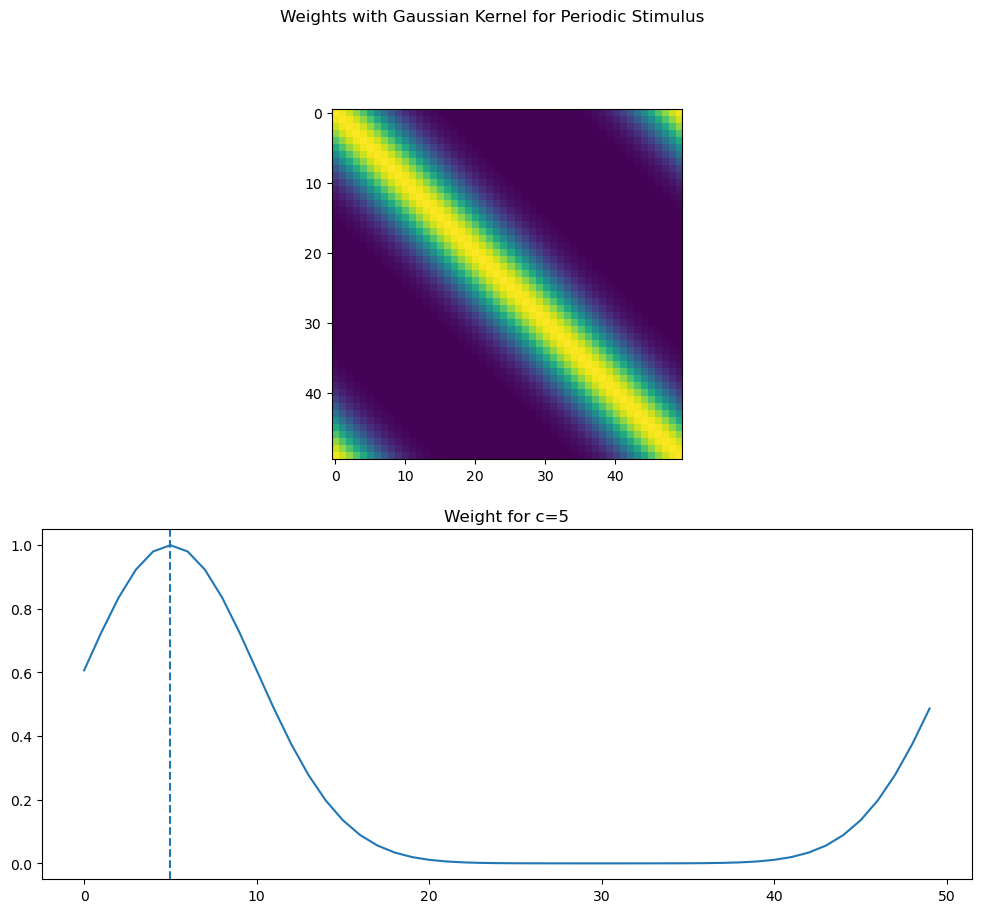

In [96]:
# Weight matrix for periodic stimulus
def weights_for_periodic_stimulus(N, a:int = 0.2):
    row_indices = np.arange(N, step=1.0).reshape(-1, 1)
    col_indices = np.arange(N, step=1.0).reshape(1, -1)
    diff_matrix = np.minimum(np.fabs(col_indices - row_indices), np.subtract(float(N), np.fabs(col_indices - row_indices)))
    print(diff_matrix)

    w = ndyn.gaussian_func(diff_matrix, a)
    return w

network = ndyn.Network(N=50, T=20, W_func=weights_for_periodic_stimulus, W_kwargs={'a': 0.2})
ndyn.plot_weight(network, 5, 'Weights with Gaussian Kernel for Periodic Stimulus')

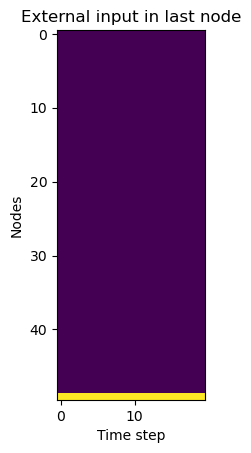

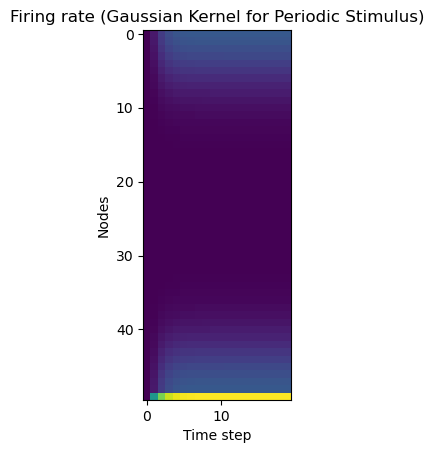

The network whose weights are adjusted for the periodic condition (ring attractor) shows neuronal activity / firing rates "wrapping around" to c=0 when there is activity in the preferred stimulus of c=49.


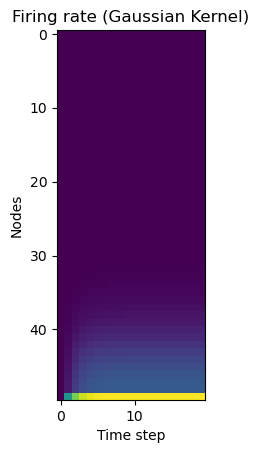

The network which is not adjusted for the periodic condition (line attractor) only shows neuronal activity / firing rates in neighboring neurons c < 49 when there is activity in the preferred stimulus of c=49.


In [97]:
nn_gaussian_kernel = ndyn.Network(N=50, T=20)

external_input = np.zeros((network.N, network.T))
external_input[49] = np.ones(network.T)
ndyn.plot_external_input(external_input, 'External input in last node')
network.simulate(external_input, ivp_func=ndyn.sp_solve_ivp, get_U_func=lambda sol: sol.y)
ndyn.plot_firing_rate(network, 'Firing rate (Gaussian Kernel for Periodic Stimulus)')
print('The network whose weights are adjusted for the periodic condition (ring attractor) shows neuronal activity / firing rates "wrapping around" to c=0 when there is activity in the preferred stimulus of c=49.')
nn_gaussian_kernel.simulate(external_input, ivp_func=ndyn.sp_solve_ivp, get_U_func=lambda sol: sol.y)
ndyn.plot_firing_rate(nn_gaussian_kernel, 'Firing rate (Gaussian Kernel)')
print('The network which is not adjusted for the periodic condition (line attractor) only shows neuronal activity / firing rates in neighboring neurons c < 49 when there is activity in the preferred stimulus of c=49.')

## Moving perturbation in external input

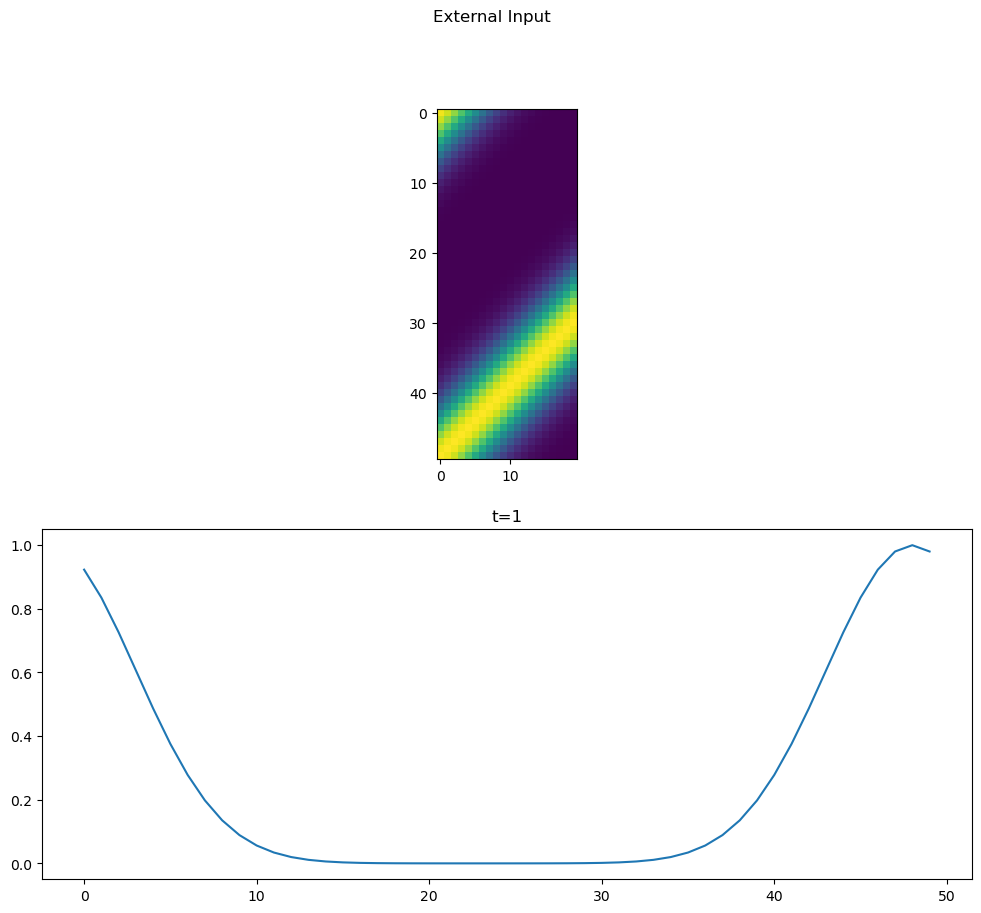

In [98]:
# External input with moving perturbation

velocity = 1
gamma = 1
t = np.tile(np.arange(0, network.T), (network.N, 1))
h = velocity * t
row_indices = np.arange(network.N, step=1.0).reshape(-1, 1)
row_indices = np.fabs(row_indices - 49) # TODO, c=25 at t=0 is undefined behavior, but it shouldn't be. The gaussian function will diverge
diff_matrix = np.minimum(np.fabs(row_indices - h), np.subtract(float(network.N), np.fabs(row_indices - h)))
external_input = ndyn.gaussian_func(diff_matrix)

ndyn.plot_external_input_at_t(external_input, 1)

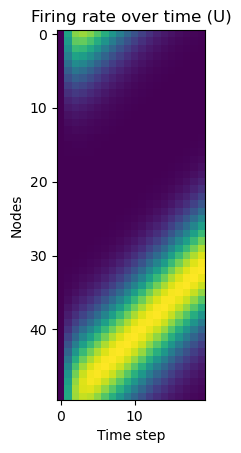

In [99]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)